# Predict metabolic flux distribution from transcriptomics data using E-Flux2 and Random Forest

### Load libraries

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import cobra
import cplex

### Load a metabolic model and parse gene-reaction rules

In [2]:
model = cobra.io.load_json_model("iJO1366.json")

In [3]:
mets = [m.id for m in model.metabolites]
rxns = [r.id for r in model.reactions]
nrow = len(mets)
ncol = len(rxns)
print(nrow, ncol)

1805 2583


In [4]:
c = [r.objective_coefficient for r in model.reactions]
S = cobra.util.create_stoichiometric_matrix(model, array_type='DataFrame')

In [5]:
gpr_dict = dict()
for r in model.reactions:
    if r.gene_reaction_rule:
        temp = set()
        for x in [x.strip('() ') for x in r.gene_reaction_rule.split(' or ')]:
            temp.add(frozenset(y.strip('() ') for y in x.split(' and ')))
        gpr_dict[r.id] = temp

## E-Flux2

### Set non-zero lower and upper bounds to 0.0 or +/-Inf

In [6]:
for r in model.reactions:
    if r.lower_bound < 0.0 and r.lower_bound > -1000.0:
        print(r.id, r.lower_bound, r.upper_bound)
        r.lower_bound = -1000.0
    elif r.lower_bound > 0.0:
        print(r.id, r.lower_bound, r.upper_bound)
        r.lower_bound = 0.0
    elif r.upper_bound > 0.0 and r.upper_bound < 1000.0:
        print(r.id, r.lower_bound, r.upper_bound)
        r.upper_bound = 1000.0
    elif r.upper_bound < 0.0:
        print(r.id, r.lower_bound, r.upper_bound)
        r.upper_bound = 0.0

EX_cbl1_LPAREN_e_RPAREN_ -0.01 1000.0
EX_glc_LPAREN_e_RPAREN_ -10.0 1000.0
ATPM 3.15 1000.0


In [7]:
for r in model.reactions:
    if r.lower_bound == -1000.0:
        r.lower_bound = -np.Inf
    if r.upper_bound == 1000.0:
        r.upper_bound = np.Inf

### Load transcriptomics data and calculate lower and upper bounds

In [8]:
Transcriptomics = pd.read_csv('ishii-trans-1.csv', index_col=0, header=None)
Transcriptomics.head()

,1
0,
b0957,45.278681
b0929,42.173087
b1480,38.351485
b3299,29.201456
b2093,36.778437


In [9]:
lb = []
ub = []
for r in model.reactions:
    if r.gene_reaction_rule:
        t = np.sum([np.min([Transcriptomics.loc[g].values if g in Transcriptomics.index 
                            else np.array([np.Inf]) for g in p])
                    for p in gpr_dict[r.id]])
        if r.lower_bound < 0.0:
            lb.append(-t)
        else:
            lb.append(r.lower_bound)
        if r.upper_bound > 0.0:
            ub.append(t)
        else:
            ub.append(r.upper_bound)
    else:
        lb.append(r.lower_bound)
        ub.append(r.upper_bound)

### Build a CPLEX model of E-Flux2 and solve

In [10]:
EFlux2 = cplex.Cplex()
EFlux2.parameters.simplex.tolerances.optimality.set(1e-9)
EFlux2.parameters.simplex.tolerances.feasibility.set(1e-9)

EFlux2.linear_constraints.add(rhs=[0]*nrow, senses='E'*nrow, names=mets)
EFlux2.variables.add(obj=c, lb=lb, ub=ub, names=rxns)
for r in model.reactions:
    for m, v in r.metabolites.items():
        EFlux2.linear_constraints.set_coefficients(m.id, r.id, v)
        
EFlux2.objective.set_sense(EFlux2.objective.sense.maximize)
EFlux2.solve()
EFlux2_sol = EFlux2.solution.get_objective_value()
print
print(EFlux2.solution.get_status_string())
print(EFlux2_sol)

CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 812 rows and 1098 columns.
Aggregator did 523 substitutions.
Reduced LP has 470 rows, 962 columns, and 4747 nonzeros.
Presolve time = 0.02 sec. (2.87 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Scaled dual infeas =             0.786571
Iteration:    86   Scaled dual infeas =             0.009009
Iteration:    88   Dual objective     =             3.664956
Iteration:   162   Dual objective     =             1.755820
Iteration:   230   Dual objective     =             1.223704
Iteration:   294   Dual objective     =             0.914004
Iteration:   356   Dual objective     =             0.698602
Perturbation started.
Iteration:   394   Dual objective     =             0.698602
Iteration:   456   Dual objective

### Build a CPLEX model to minimize L2 norm and solve

In [11]:
Q = [1.0 for r in model.reactions]

In [12]:
EFlux2_min = cplex.Cplex()
EFlux2_min.parameters.simplex.tolerances.optimality.set(1e-9)
EFlux2_min.parameters.simplex.tolerances.feasibility.set(1e-9)

EFlux2_min.linear_constraints.add(rhs=[0]*nrow, senses='E'*nrow, names=mets)
EFlux2_min.variables.add(obj=[0]*ncol, lb=lb, ub=ub, names=rxns)
for r in model.reactions:
    for m, v in r.metabolites.items():
        EFlux2_min.linear_constraints.set_coefficients(m.id, r.id, v)

EFlux2_min.variables.set_lower_bounds('Ec_biomass_iJO1366_core_53p95M', 1.0*EFlux2_sol)
EFlux2_min.objective.set_quadratic(Q)
EFlux2_min.objective.set_sense(EFlux2_min.objective.sense.minimize)
EFlux2_min.solve()
EFlux2_min_sol = EFlux2_min.solution.get_objective_value()
EFlux2_min.solution.get_status_string()

CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
QP Presolve eliminated 235 rows and 259 columns.
Reduced QP has 1570 rows, 2324 columns, and 9095 nonzeros.
Reduced QP objective Q matrix has 2324 nonzeros.
Presolve time = 0.01 sec. (1.50 ticks)
Parallel mode: using up to 32 threads for barrier.

***NOTE: Found 2 dense columns.

Number of nonzeros in lower triangle of A*A' = 8874
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (1.32 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 32
  Rows in Factor            = 1572
  Integer space required    = 5931
  Total non-zeros in factor = 26893
  Total FP ops to factor    = 803867
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   9.9323679e+06  -5.1907136e+07  8.91e+04  1.30e

'optimal'

### Get the E-Flux2 solution and plot against 13C experimental data

In [13]:
# E-Flux2 solution
EFlux2_fluxdict = dict(zip(rxns,EFlux2_min.solution.get_values()))
# Ishii flux data, WT reference strain [mmol/gDW/h]: http://ecoli.iab.keio.ac.jp/ > Fluxome > Fluxome data
reactionDict = {'PGI':2076,'PFK':2063,'FBA':1150,'TPI':2455,'PYK':2265,'PDH':2046,'GND':1422,'RPE':2311,'RPI':2312,'TALA':2397,'ICL':1551,'MALS':1713}
ishiiDict = {2076:2.247179186,2063:2.495301258,1150:2.495301258,2455:2.495301258,2265:1.399624166,2046:3.722827564,1422:.6439079794,2311:.2684455913,2312:.3754514687,2397:.1783978343,1551:.3268244693,1713:.3268244693}

In [14]:
Exp, EFlux2_flux = [],[]
for k, v in reactionDict.items():
    Exp.append(ishiiDict[v])
    EFlux2_flux.append(EFlux2_fluxdict[k])
Exp = np.array(Exp)
EFlux2_flux = np.array(EFlux2_flux)

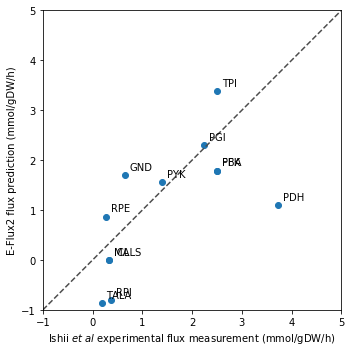

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(Exp,EFlux2_flux)
ax.set_xlim(-1,5)
ax.set_ylim(-1,5)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
Labels = [i for i in reactionDict]
for i in range(len(Exp)):
    xy = (Exp[i]+.1,EFlux2_flux[i]+.1)
    ax.annotate(Labels[i],xy)
plt.xlabel(r'Ishii $et$ $al$ experimental flux measurement (mmol/gDW/h)')
plt.ylabel(r'E-Flux2 flux prediction (mmol/gDW/h)')
plt.tight_layout()
plt.show()

## SPOT

### Split reversible reactions into two irreversible reactions

In [16]:
rev_rxns = ['rev_'+r.id for r in model.reactions if r.reversibility]
rev_ncol = len(rev_rxns)
print(rev_ncol)

636


In [17]:
lb = [0.0 if r.reversibility else r.lower_bound for r in model.reactions] + [0.0 for r in model.reactions if r.reversibility]
ub = [r.upper_bound for r in model.reactions] + [-r.lower_bound for r in model.reactions if r.reversibility]

### Calculate objective function coefficients from transcriptomics

In [18]:
c = []
for r in model.reactions:
    if r.gene_reaction_rule:
        t = np.sum([np.min([Transcriptomics.loc[g].values if g in Transcriptomics.index 
                            else np.array([np.Inf]) for g in p])
                    for p in gpr_dict[r.id]])
        if t == np.Inf:
            t = 0
        c.append(t)
    else:
        c.append(0.0)
for r in model.reactions:
    if r.reversibility:
        if r.gene_reaction_rule:
            t = np.sum([np.min([Transcriptomics.loc[g].values if g in Transcriptomics.index 
                                else np.array([np.Inf]) for g in p])
                        for p in gpr_dict[r.id]])
            if t == np.Inf:
                t = 0
            c.append(t)
        else:
            c.append(0.0)

### Build a CPLEX model of SPOT and solve

In [19]:
SPOT = cplex.Cplex()
SPOT.parameters.simplex.tolerances.optimality.set(1e-9)
SPOT.parameters.simplex.tolerances.feasibility.set(1e-9)

SPOT.linear_constraints.add(rhs=[0]*nrow, senses='E'*nrow, names=mets)
SPOT.variables.add(obj=c, lb=lb, ub=ub, names=rxns+rev_rxns)
for r in model.reactions:
    for m, v in r.metabolites.items():
        SPOT.linear_constraints.set_coefficients(m.id, r.id, v)
for r in model.reactions:
    if r.reversibility:
        for m, v in r.metabolites.items():
            SPOT.linear_constraints.set_coefficients(m.id, 'rev_'+r.id, -v)
SPOT.quadratic_constraints.add(quad_expr=[rxns+rev_rxns, rxns+rev_rxns, [1]*len(c)],
                               sense='L', rhs=100000.0, name='L2norm')
SPOT.objective.set_sense(SPOT.objective.sense.maximize)
SPOT.solve()
SPOT_sol = SPOT.solution.get_objective_value()
print
print(SPOT.solution.get_status_string())
print(SPOT_sol)

CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
QCP Presolve eliminated 199 rows and 222 columns.
Reduced QCP has 4604 rows, 2998 columns, and 13937 nonzeros.
Reduced QCP has 1 quadratic constraints.
Presolve time = 0.01 sec. (2.32 ticks)
Parallel mode: using up to 32 threads for barrier.

***NOTE: Found 3 dense columns.

Number of nonzeros in lower triangle of A*A' = 19608
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (1.72 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 32
  Rows in Factor            = 4604
  Integer space required    = 12299
  Total non-zeros in factor = 52314
  Total FP ops to factor    = 1022224
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf Inf Ratio
   0   0.0000000e+00   0.0000000e+00  3.31e+03  0.00e+0

### Get the SPOT solution and plot against 13C experimental data

In [20]:
SPOT_fluxdict = dict(zip(rxns,SPOT.solution.get_values()))

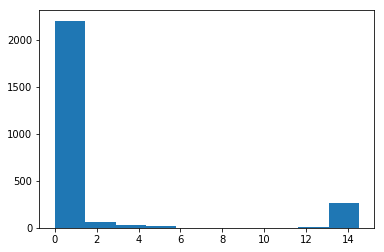

In [21]:
plt.hist(SPOT_fluxdict.values())
plt.show()

In [22]:
SPOT_flux = []
for k, v in reactionDict.items():
    SPOT_flux.append(SPOT_fluxdict[k])
SPOT_flux = np.array(SPOT_flux)

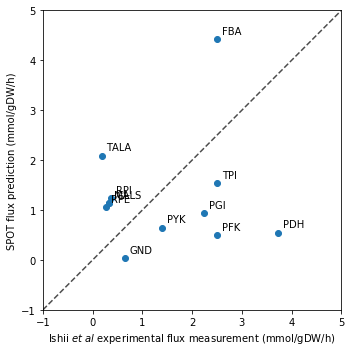

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(Exp,SPOT_flux)
ax.set_xlim(-1,5)
ax.set_ylim(-1,5)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
Labels = [i for i in reactionDict]
for i in range(len(Exp)):
    xy = (Exp[i]+.1,SPOT_flux[i]+.1)
    ax.annotate(Labels[i],xy)
plt.xlabel(r'Ishii $et$ $al$ experimental flux measurement (mmol/gDW/h)')
plt.ylabel(r'SPOT flux prediction (mmol/gDW/h)')
plt.tight_layout()
plt.show()

## Random Forest

### Load Ishii flux data

In [24]:
# Load reaction names
reactionNames = np.loadtxt('ishii-flux-names.csv', delimiter=',', skiprows=0, usecols=0, dtype='str')
# Load train and test data
# Training data is from eflux2 samples 2 to 8, representing different KEIO KO strains and growth conditions
# Test data is eflux2 sample1, the WT reference sample
train_x, train_y = [],[]
for i in range(2,9):
    train_x.append(np.loadtxt('ishii-trans-'+str(i)+'.csv', delimiter=',', skiprows=0, usecols=1))
    train_y.append(np.loadtxt('ishii-flux-'+str(i)+'.csv'))
test_x, test_y = np.loadtxt('ishii-trans-1.csv', delimiter=',', skiprows=0, usecols=1), np.loadtxt('ishii-flux-1.csv')
train_x, train_y = np.array(train_x), np.array(train_y)

### Define and run random forest for each reaction

In [25]:
# Load data into arrays for plotting
RF_array, eflux2, absError = [],[],[]
for r in range(len(reactionNames)):
    # Define type of random forest
    rf = RandomForestRegressor(n_estimators=20, oob_score=False, random_state=0, n_jobs=8, max_features=10, max_leaf_nodes=10)
    rf.fit(train_x, train_y[:,r])
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_x.reshape(1, -1))
    i = r
    print('Working on reaction:', reactionNames[i])
    print('   Random Forest:', predictions[0], '|   Eflux2 prediction:', test_y[i])
    RF_array.append(predictions[0])
    eflux2.append(float(test_y[i]))
    absError.append(abs(predictions[0]-float(test_y[i])))
RF_array = np.array(RF_array)
eflux2 = np.array(eflux2)

Working on reaction: R_DM_4CRSOL
   Random Forest: 7.058428571428574e-05 |   Eflux2 prediction: 7.47e-05
Working on reaction: R_DM_5DRIB
   Random Forest: 7.121214285714286e-05 |   Eflux2 prediction: 7.53e-05
Working on reaction: R_DM_AACALD
   Random Forest: 1.4368571428571425e-15 |   Eflux2 prediction: 8.65e-16
Working on reaction: R_DM_AMOB
   Random Forest: 6.330928571428571e-07 |   Eflux2 prediction: 6.7e-07
Working on reaction: R_DM_MTHTHF
   Random Forest: 0.00014169999999999997 |   Eflux2 prediction: 0.00015
Working on reaction: R_DM_OXAM
   Random Forest: 2.9044664285714286e-13 |   Eflux2 prediction: 7.38e-12
Working on reaction: R_Ec_biomass_iJO1366_WT_53p95M
   Random Forest: 6.894428571428571e-17 |   Eflux2 prediction: 1.1e-15
Working on reaction: R_Ec_biomass_iJO1366_core_53p95M
   Random Forest: 0.32302039529999993 |   Eflux2 prediction: 0.334827489
Working on reaction: R_EX_12ppd_DASH_R_LPAREN_e_RPAREN_
   Random Forest: 4.225843571428571e-12 |   Eflux2 prediction: 7.22e

### Find optimal stoichiometric nudge - very slow, need to update using CPLEX or conopt

In [27]:
xf = np.transpose(RF_array)
x0 = np.zeros(len(test_y))+.000005

# Weight factor for relative importance of Sv over the length of the nudging vector= b
weightFactor = 1000.0
print('Initial ||Sv|| = ',np.dot(np.matmul(S.values,xf),np.matmul(S.values,xf)))
print('   Now find nudging vector minimizeResult.x which reduces Sv to zero')

def rosen(x):
    adjusted_fluxes =xf[:]-x[:]
    a = np.matmul(S.values,adjusted_fluxes)
    Sloss = np.dot(a,a)*weightFactor
    bLength = sum((x[:])**2)
    
    # Get occasional updates on solver progress
    if np.random.rand()<.001:
        print('||S(v-b)||=',Sloss/weightFactor,', ||b||=',bLength)
    return bLength + Sloss

# Minimize f = ||S(v-b)||*weightFactor + ||b||
minimizeResult = minimize(rosen, x0, method='BFGS', options={'disp': True})

Initial ||Sv|| =  15.548938970576682
   Now find nudging vector minimizeResult.x which reduces Sv to zero
||S(v-b)||= 15.528776676548889 , ||b||= 6.457514923365838e-08
||S(v-b)||= 15.528776611869986 , ||b||= 6.457514923365838e-08
||S(v-b)||= 15.528776510389735 , ||b||= 6.457514923365838e-08
||S(v-b)||= 15.528776674761998 , ||b||= 6.457514923365838e-08
||S(v-b)||= 27147.274466117295 , ||b||= 1.0201711600169099
||S(v-b)||= 12.517549954608315 , ||b||= 0.00011166132498103328
||S(v-b)||= 12.517549971863643 , ||b||= 0.0001116613285776238
||S(v-b)||= 12.517549987852293 , ||b||= 0.00011166132368967279
||S(v-b)||= 8.061969744292288 , ||b||= 0.0016598123265141131
||S(v-b)||= 8.061969714101778 , ||b||= 0.0016598123451563589
||S(v-b)||= 5.344398331829254 , ||b||= 0.02581460472593586
||S(v-b)||= 5.344398331829133 , ||b||= 0.025814604725935872
||S(v-b)||= 3.8288159037830756 , ||b||= 0.08064537504367639
||S(v-b)||= 3.8288158961728316 , ||b||= 0.0806453748578039
||S(v-b)||= 5.136700301861972 , ||b||= 

### Apply the stoichiometric nudge to the Random Forest solution and plot against E-Flux2 and 13C experimental data 

In [28]:
# Use the forest's predict method on the test data
predictions = RF_array - minimizeResult.x
# Calculate the absolute errors of random forest vs eflux2
allAbsError = abs(predictions - test_y)

In [29]:
# Load data into arrays for plotting
RF_flux, eflux2, absError = [],[],[]
for i in reactionDict.values():
    print('Working on reaction:',reactionNames[i])
    print('   Random Forest:',predictions[i],'Eflux2 prediction:',test_y[i])
    RF_flux.append(predictions[i])
    eflux2.append(float(test_y[i]))
    absError.append(abs(predictions[i]-float(test_y[i])))
RF_flux = np.array(RF_flux)
eflux2 = np.array(eflux2)

Working on reaction: R_PGI
   Random Forest: 2.2874260574506766 Eflux2 prediction: 2.296128682
Working on reaction: R_PFK
   Random Forest: 2.1786512924341044 Eflux2 prediction: 1.790151679
Working on reaction: R_FBA
   Random Forest: 2.175030970706799 Eflux2 prediction: 1.790151679
Working on reaction: R_TPI
   Random Forest: 3.9963307014967064 Eflux2 prediction: 3.378207362
Working on reaction: R_PYK
   Random Forest: 2.926898522888226 Eflux2 prediction: 1.563415101
Working on reaction: R_PDH
   Random Forest: 0.5980778723893255 Eflux2 prediction: 1.100181514
Working on reaction: R_GND
   Random Forest: 1.9869858040410973 Eflux2 prediction: 1.691451557
Working on reaction: R_RPE
   Random Forest: 1.076179787587757 Eflux2 prediction: 0.867799311
Working on reaction: R_RPI
   Random Forest: -0.8989858289232927 Eflux2 prediction: -0.810324773
Working on reaction: R_TALA
   Random Forest: -1.0341074221235633 Eflux2 prediction: -0.861606754
Working on reaction: R_ICL
   Random Forest: 0.2

In [30]:
RF_flux = RF_array

ValueError: x and y must be the same size

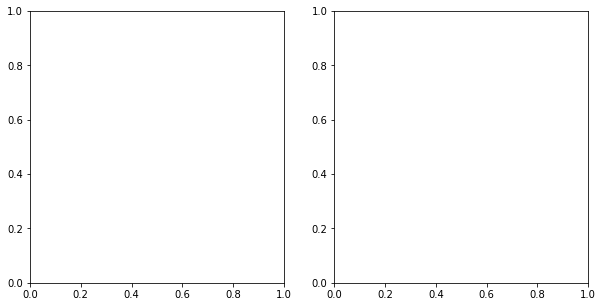

In [31]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(EFlux2_flux,RF_flux)
ax1.set_xlim(-2,5)
ax1.set_ylim(-2,5)
ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
Labels = [i for i in reactionDict]
for i in range(len(EFlux2_flux)):
    xy = (EFlux2_flux[i]+.1,RF_flux[i]+.1)
    ax1.annotate(Labels[i],xy)
ax1.set_xlabel(r'E-Flux2 flux prediction (mmol/gDW/h)')
ax1.set_ylabel(r'Random Forest flux prediction (mmol/gDW/h)')

ax2.scatter(Exp,RF_flux)
ax2.set_xlim(-2,5)
ax2.set_ylim(-2,5)
ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", c=".3")
Labels = [i for i in reactionDict]
for i in range(len(Exp)):
    xy = (Exp[i]+.1,RF_flux[i]+.1)
    ax2.annotate(Labels[i],xy)
ax2.set_xlabel(r'Ishii $et$ $al$ experimental flux measurement (mmol/gDW/h)')
ax2.set_ylabel(r'Random Forest flux prediction (mmol/gDW/h)')

plt.tight_layout()
plt.show()

In [ ]:
# Histogram plot of errors
g=sns.distplot(absError,hist=True)
plt.xlabel(r'Abolute error of Random Forest vs Eflux2 base (mmol/gDW/h)')
plt.ylabel(r'Normalized frequency')
plt.xlim(0,3)
#plt.show()
#plt.savefig('rf-eflux2-nudging-error.pdf')

In [ ]:
# Zoom of histogram error
g=sns.distplot(absError,hist=True)
plt.xlabel(r'Abolute error of Random Forest vs Eflux2 base (mmol/gDW/h)')
plt.ylabel(r'Normalized frequency')
plt.xlim(0,3)
plt.ylim(0,1.5)
#plt.show()
#plt.savefig('rf-eflux2-error-nudging-zoom.pdf')

In [ ]:
# Histogram plot of all errors
g=sns.distplot(allAbsError,hist=True)
plt.xlabel(r'Abolute error of Random Forest vs Eflux2 base (mmol/gDW/h)')
plt.ylabel(r'Normalized frequency')
plt.xlim(0,3)
#plt.show()
#plt.savefig('rf-eflux2-allReactions-nudging-error.pdf')

In [ ]:
# Zoom of histogram all errors
g=sns.distplot(allAbsError,hist=True)
plt.xlabel(r'Abolute error of Random Forest vs Eflux2 base (mmol/gDW/h)')
plt.ylabel(r'Normalized frequency')
plt.xlim(0,3)
plt.ylim(0,.2)
#plt.show()
#plt.savefig('rf-eflux2-allReactions-error-nudging-zoom.pdf')